# Diffusion Models

### Background

Forward Process
$$q(x_t| x_{t-1}) = \mathcal{N}(x_t, \sqrt{1-\beta}x_{t-1}, \beta I)$$
*The $\sqrt{1-\beta}x_{t-1}$ is to retain information about previous step to be able to reconstruct in reverse process, and ensure the contribution of $x_{t-1}$ to the variance scales properly*
Generally, $$q(x_t|x_0) = \mathcal{N}(x_t, \sqrt(\prod_0^t1-\beta_t)x_0, \beta_t I)$$


Reverse Process 

*Predict the noise distribution at timestep $t$ to get $x_t$ from $x_{t-1}$*
$$p_\theta (x_{t-1}|x_t) = \mathcal{N}(x_{t-1}|\mu_\theta(x_t,t), \Sigma_\theta(x_t, t))$$

Maximize expected probability of reconstructing the original image over your true distribution:
$$
\begin{aligned}
\argmax_\theta \mathbb{E}_{q(x_0)}[\log p_\theta(x_0)] \quad & \\
= \argmax_\theta \mathbb{E}_{q(x_0)}[\log \int p_\theta(x_{0:T}) \, dx_{1:T}] \quad & \text{Represent as marginal} \\
= \argmax_\theta \mathbb{E}_{q(x_0)}[\log \int q(x_{1:T}|x_0) \frac{p_\theta(x_{0:T}) }{q(x_{1:T}| x_0)} \, dx_{1:T}] \quad & \text{Importance sampling trick from known distribution, forward process $q(x_{1:T}| x_0)$} \\
= \argmax_\theta \mathbb{E}_{q(x_0)}[ \log \mathbb{E}_{q(x_{1:T}|x_0)}\left[\frac{p_\theta(x_{0:T})}{q(x_{1:T}| x_0)}\right]] \quad & \text{Definition of expectation} \\
= \argmin_\theta \mathbb{E}_{q(x_0)}\left[ -\log \mathbb{E}_{q(x_{1:T}|x_0)}\left[\frac{p_\theta(x_{0:T})}{q(x_{1:T}| x_0)}\right]\right] \quad &  \\
\leq \argmin_\theta \mathbb{E}_{q(x_{0:T})}\left[-\log \frac{p_\theta(x_{0:T})}{q(x_{1:T}| x_0)}\right] \quad & \text{Jensen's Inequality, $-\log$ is convex} \\
\ldots \quad & \text{Simplifies to...} \\
\argmin_\theta \mathbb{E}_{t,x_0,\epsilon}\left[\left|\left|\epsilon - \epsilon_\theta(x_t, t)\right|\right|^2 \right]  \quad &  \\
\argmin_\theta \mathbb{E}_{t,x_0,\epsilon}\left[\left|\left|\epsilon - \epsilon_\theta\left(\sqrt{\alpha_{t}}x_0 + \sqrt{1-\alpha_{t}}\epsilon, t\right)\right|\right|^2 \right] \quad & 
\end{aligned} 
$$


In [9]:
import torch
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image
from tqdm.notebook import tqdm
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter


In [17]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        super().__init__()
        self.file_list = file_list
        
    def __len__(self,):
        return len(self.file_list)
 
    def __getitem__(self, index):
        image_path = f"./data/img_align_celeba/img_align_celeba/{self.file_list[index]}"
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224,224))

        image = torch.tensor(image, dtype=torch.float32) / 255

        #scale from 0,1 to -1,1
        image = image * 2 - 1

        return image

In [18]:
class DownSample(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding=1)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.bn = torch.nn.BatchNorm2d(out_channels) 

    def forward(self, x): # returns (feature map before pool, feature map after max pooling)
        pre_pool = self.conv1(x)
        pre_pool = self.conv2(pre_pool)
        # pre_pool = torch.nn.functional.batch_norm(pre_pool)
        pre_pool = torch.nn.functional.relu(pre_pool)


        post_pool = self.pool(pre_pool)

        return pre_pool, post_pool

class UpSample(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(2,2), stride=2)
        self.conv1 = torch.nn.Conv2d(out_channels*2, out_channels, kernel_size=(3,3), padding=1)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), padding=1)
        self.bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x, pre_pool): 
        x = self.upconv(x)

        # x and pre_pool are (B, C, H, W)
        # we concat across channels

        # # copy and crop
        # x_h, x_w = x.shape[2], x.shape[3]
        # pre_pool_h, pre_pool_w = pre_pool.skhape[2], pre_pool.shape[3]
        # dh, dw = pre_pool_h - x_h, pre_pool_w - x_w
        # pre_pool_cropped = pre_pool[:,:, dh//2: dh//2 + x_h, dw//2: dw//2 + x_w]

        # pad
        x_h, x_w = x.shape[2], x.shape[3]
        pre_pool_h, pre_pool_w = pre_pool.shape[2], pre_pool.shape[3]
        dh, dw = pre_pool_h - x_h, pre_pool_w - x_w
        pad = [
            dh // 2, math.ceil(dh / 2),
            dw // 2, math.ceil(dw / 2),
        ]
        padded_x = torch.nn.functional.pad(x, pad)

        x = torch.cat([padded_x, pre_pool], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.bn(x)
        x = torch.nn.functional.relu(x)
        
        return x
    
class UNet(torch.nn.Module):
    def __init__(self, image_shape=(3,224,244)):
        super().__init__()
        im_channels, im_height, im_width = image_shape
        self.down1 = DownSample(im_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
    
        self.middle_conv1 = torch.nn.Conv2d(512, 1024, kernel_size=(3,3), padding=0)
        self.middle_conv2 = torch.nn.Conv2d(1024, 1024, kernel_size=(3,3), padding=0)

        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)

        self.final_layer = torch.nn.Conv2d(64, 3, kernel_size=(3,3), padding=1)

    def forward(self,x):
        down1_feat, down1 = self.down1(x)
        down2_feat, down2 = self.down2(down1)
        down3_feat, down3 = self.down3(down2)
        down4_feat, down4 = self.down4(down3)

        middle1 = self.middle_conv1(down4)
        middle2 = self.middle_conv2(middle1)

        up1 = self.up1(middle2, down4_feat)
        up2 = self.up2(up1, down3_feat)
        up3 = self.up3(up2, down2_feat)
        up4 = self.up4(up3, down1_feat)

        output = self.final_layer(up4)

        return output

class DiffusionModel(torch.nn.Module):
    BETA_START = 1e-4
    BETA_END = 0.02
    MAX_TIMESTEPS = 1000
    IMG_SIZE = 224

    def __init__(self, device):
        super().__init__()


        self.betas = torch.linspace(self.BETA_START, self.BETA_END, self.MAX_TIMESTEPS)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)

        # architecture
        self.net = UNet(image_shape=(3, self.IMG_SIZE, self.IMG_SIZE))

    def forward(self, input):
        return self.net(input)

    def apply_noise(self, image_batch, noise_batch, timestep):
        # noised image
        # sqrt(alpha_t) * img + sqrt(1 - alpha_t) * noise
        return torch.sqrt(self.alpha_bars[timestep]) * image_batch + torch.sqrt(1 - self.alpha_bars[timestep]) * noise_batch


In [21]:
splits = pd.read_csv("./data/img_align_celeba/list_eval_partition.csv")

train_list = splits[splits["partition"] == 0]["image_id"].values[:1000]
val_list = splits[splits["partition"] == 1]["image_id"].values[:100]

train_ds = ImageDataset(train_list)
val_ds = ImageDataset(val_list)
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    # num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=32,
    shuffle=True,
)


In [ ]:
# Check that MPS is available
device = None
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

model = DiffusionModel(device)
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr = 1e-4)

writer = SummaryWriter(log_dir="runs/ddpm")

train_losses = []
val_losees = [0]
for epoch in range(100):
    print(f"Training Epoch {epoch}")
    losses = []
    model.train()
    for i, input in enumerate(train_loader):
        optim.zero_grad()

        input = input.to(device)

        noise = torch.randn_like(input)
        noise = noise.to(device)
        noise_steps = torch.randint(0, model.MAX_TIMESTEPS, (1,))
        noised_input = model.apply_noise(input, noise, noise_steps)

        pred_noise = model(noised_input.permute(0, 3, 1, 2))
        loss = torch.nn.functional.mse_loss(pred_noise, noise.permute(0, 3, 1, 2))
        losses.append(loss.item())

        loss.backward()
        optim.step()

    train_losses.append(np.mean(losses))

    # with torch.no_grad():
    #     print(f"Validation Epoch {epoch}")
    #     losses = []
    #     model.eval()
    #     for i, input in enumerate(val_loader):
    #         input = input.to(device)

    #         noise = torch.randn_like(input)
    #         noise = noise.to(device)
    #         noise_steps = torch.randint(0, model.MAX_TIMESTEPS, (1,))
    #         noised_input = model.apply_noise(input, noise, noise_steps)

    #         pred_noise = model(noised_input.permute(0, 3, 1, 2))
    #         loss = torch.nn.functional.mse_loss(pred_noise, noise.permute(0, 3, 1, 2))
    #         losses.append(loss.item())

    #     val_losses.append(np.mean(losses))
    
    print(f"Epoch {epoch} | Train Loss: {train_losses[-1]} Validation Loss: {val_losees[-1]}")
    writer.add_scalar("Train Loss", train_losses[-1], epoch)
    # writer.add_scalar("Validation Loss", val_losses[-1], epoch)

    
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"{writer.get_logdir()}/epoch_{epoch}.pt")

writer.close()


    # pred = model(noised_input.permute(0, 3, 1, 2))
    # pred = pred.permute(0, 2,3, 1)

    # original = input[0] / 2 + 0.5
    # noised = noised_input[0] / 2  + 0.5
    # pred_noise = pred[0] / 2 + 0.5

    # original, noised, pred_noise = original.detach().cpu(), noised.detach().cpu(), pred_noise.detach().cpu()
    # plt.imshow(torch.cat([original, noised, pred_noise], dim=1))
    # break



Using device: cuda
Training Epoch 0
Epoch 0 | Train Loss: 0.5719631910324097 Validation Loss: 0
Training Epoch 1
Epoch 1 | Train Loss: 0.1158794283401221 Validation Loss: 0
Training Epoch 2
Epoch 2 | Train Loss: 0.09371215454302728 Validation Loss: 0
Training Epoch 3
Epoch 3 | Train Loss: 0.08891093474812806 Validation Loss: 0
Training Epoch 4
Epoch 4 | Train Loss: 0.09380562859587371 Validation Loss: 0
Training Epoch 5
Epoch 5 | Train Loss: 0.08645352208986878 Validation Loss: 0
Training Epoch 6
Epoch 6 | Train Loss: 0.08366422727704048 Validation Loss: 0
Training Epoch 7
Epoch 7 | Train Loss: 0.05823957233224064 Validation Loss: 0
Training Epoch 8
Epoch 8 | Train Loss: 0.04760651965625584 Validation Loss: 0
Training Epoch 9
Epoch 9 | Train Loss: 0.048806674662046134 Validation Loss: 0
Training Epoch 10
Epoch 10 | Train Loss: 0.04014575848123059 Validation Loss: 0
Training Epoch 11
Epoch 11 | Train Loss: 0.035656163876410574 Validation Loss: 0
Training Epoch 12
Epoch 12 | Train Loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(5.0252, device='mps:0', grad_fn=<MaxBackward1>) tensor(0., device='mps:0', grad_fn=<MinBackward1>)
tensor(4.9914) tensor(-5.5141)


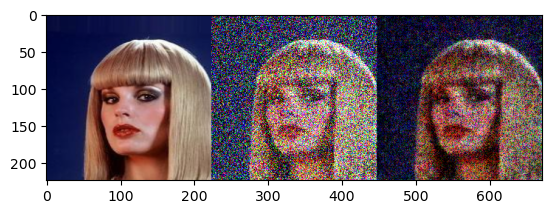

In [28]:
noise = torch.randn((1, 3, 224, 224)).to(device)
# noise_steps = torch.randint(0, model.MAX_TIMESTEPS, (1,))
# noised_input = model.apply_noise(input, noise, noise_steps)
for samples in val_loader:
    sample = samples[0].permute(2,0,1).to(device)

    noise = sample + noise
    pred_noise = model(noise)
    print(pred_noise.max(), pred_noise.min())

    img = (noise - pred_noise)[0].permute(1,2,0).detach().cpu()
    sample = sample.permute(1,2,0).detach().cpu()
    noise = noise[0].permute(1,2,0).detach().cpu()

    # plt.imshow(img / 2 + 0.5)

    test = torch.cat([sample, noise, img], dim=1)
    print(test.max(), test.min())
    plt.imshow(torch.cat([sample, noise, img], dim=1) / 2 + 0.5)
    break